In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.util import operators
from src.util import bath_correlation_function
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val
from src.hops import hops_rk_simple

In this notebook we want to compute the dynamics of the spin-boson model, using the non-linear HOPS equation

\begin{equation}
    \frac{\partial}{\partial t}\tilde{\Psi}_t^{(k)} = \left(-iH-k\omega+\tilde{z}_t^*L\right)\tilde{\Psi}_t^{(k)} + k\alpha(0)L\tilde{\Psi}_t^{(k-1)} - \left(L^\dagger - \left\langle L^\dagger\right\rangle_t\right)\tilde{\Psi}_t^{(k+1)},
\end{equation}

where

\begin{equation}
    \tilde{z}_t^* = z_t^*+\int_0^t\text{ds}\alpha^*(t-s)\left\langle L^{\dagger}\right\rangle_s.
\end{equation}

We will use RK4 to integrate the state, compare to the linear HOPS equation:

\begin{equation}
\begin{split}
    y_{n+1} & = y_{n} + \frac{1}{6}\left(k_1 + 2k_2 + 2k_3 + k_4\right)\cdot h \\
    t_{n+1} & = t_n + h,
\end{split}
\end{equation}

where

\begin{equation}
\begin{split}
    k_1 & = f\left(t_n, y_n\right), \\
    k_2 & = f\left(t_n + \frac{h}{2}, y_n + h\frac{k_1}{2}\right), \\
    k_3 & = f\left(t_n + \frac{h}{2}, y_n + h\frac{k_2}{2}\right), \\
    k_4 & = f\left(t_n + h, y_n + hk_3\right).
\end{split}
\end{equation}

Again we will have to define the function $f$ computing the R.H.S. of the HOPS equation:

\begin{equation}
    f^{(k)}\left(t, \boldsymbol{\Psi}_t\right) = \frac{\partial}{\partial t} \boldsymbol{\Psi}_t
\end{equation}

We will again work with a vector of states

\begin{equation}
    \boldsymbol{\Psi}_t \equiv
    \begin{pmatrix}
    \Psi_t^{(0)} \\
    \Psi_t^{(1)} \\
    \vdots \\
    \Psi_t^{(N_\text{trunc}-1)} \\
    \end{pmatrix}
\end{equation}

We can split the function into a "linear", a "non-linear" and a "noise" part:

\begin{equation}
f^{(k)}\left(t, \boldsymbol{\Psi}_t\right) = \left(M_\text{linear} + \tilde{z}_t^* \cdot M_\text{noise} + \left\langle L^\dagger\right\rangle \cdot M_\text{non-linear}\right) \boldsymbol{\Psi}_t.
\end{equation}

The linear and noise propagator are equal to the propagators in the linear HOPS equation:

\begin{equation}
    M_\text{linear} =
    \begin{pmatrix}
        -iH         & -L^\dagger           & 0                      & \cdots     &        &        & 0 \\
        \alpha(0)L  & -iH-\omega\mathbb{1} & -L^{\dagger}           & 0          & \cdots &        & 0 \\
        0           & 2\alpha(0)L          & -iH-2\omega\mathbb{1}  & -L^\dagger & 0      & \cdots & 0 \\
        \vdots      & \vdots               & \vdots                 & \vdots     & \vdots & \vdots & \vdots \\
    \end{pmatrix}
\end{equation}
\begin{equation}
    M_\text{noise} =
    \begin{pmatrix}
        L      & 0      & \cdots &        \\
        0      & L      & 0      & \cdots \\
        \vdots & 0      & L      & \ddots \\
               & \vdots & \ddots & \ddots \\
    \end{pmatrix}
\end{equation}
The non-linear propagator only has identitys on the diagonal shifted up one entry:
\begin{equation}
    M_\text{non-linear} = 
    \begin{pmatrix}
        0      & \mathbb{1} & \cdots     &        \\
        0      & 0          & \mathbb{1} & \cdots \\
        \vdots & 0          & 0          & \ddots \\
               & \vdots & \ddots & \ddots \\
    \end{pmatrix}
\end{equation}

The expectation value of $L^\dagger$ can be easily computed if we have the state at time $t$:

\begin{equation}
    \left\langle L^\dagger\right\rangle_t = \frac{\left\langle\Psi^{(0)}_t\right|L^\dagger\left|\Psi^{(0)}_t\right\rangle}{\left\langle\Psi^{(0)}_t\middle|\Psi^{(0)}_t\right\rangle}
\end{equation}

The last remaining problem is the computation of the shifted noise

\begin{equation}
    \tilde{z}_t^* = z_t^*+\int_0^t\text{ds}\alpha^*(t-s)\left\langle L^{\dagger}\right\rangle_s
\end{equation}

which contains the "memory term"

\begin{equation}
    z^*_\text{memory}(t) \equiv \int_0^t\text{ds}\alpha^*(t-s)\left\langle L^{\dagger}\right\rangle_s
\end{equation}

To avoid recalculating the memory term at each step, we can also derive an iterative update equation using some approximations:

\begin{equation}
\begin{split}
    z^*_\text{memory}(t+dt) &= \int_0^{t+dt}\text{ds}\,\alpha^*(t+\Delta t-s)\left\langle L^{\dagger}\right\rangle_s = e^{-\omega^*\Delta t} \int_0^{t+dt}\text{ds}\,\alpha^*(t-s)\left\langle L^{\dagger}\right\rangle_s \\
    &= e^{-\omega^*\Delta t} z^*_\text{memory}(t) + e^{-\omega^*\Delta t} \int_t^{t+dt}\text{ds}\,\alpha^*(t-s)\left\langle L^{\dagger}\right\rangle_s \\
    &\approx e^{-\omega^*\Delta t} z^*_\text{memory}(t) + e^{-\omega^*\Delta t} \Delta t \alpha^*(0) \left\langle L^{\dagger}\right\rangle_t \\
    &\approx z^*_\text{memory}(t) - \omega^*\Delta t \, z^*_\text{memory}(t) + \Delta t \, g^* \left\langle L^{\dagger}\right\rangle_t
\end{split}
\end{equation}

With this we can update the memory terms using runge-kutta:

\begin{equation}
\begin{split}
    z^*_\text{memory}(t_{n+1}) & = z^*_\text{memory}(t_n) + \frac{1}{6}\left(k_1 + 2k_2 + 2k_3 + k_4\right)\cdot \Delta t \\
    t_{n} & = t_0 + n\cdot\Delta t,
\end{split}
\end{equation}

where

\begin{equation}
\begin{split}
    k_1^\prime & = g\left(z^*_\text{memory}(t_{n}),\, t_n,\, y_n\right), \\
    k_2^\prime & = g\left(z^*_\text{memory}(t_{n}) + \frac{\Delta t}{2}k_1^\prime,\, t_{n+1},\, y_n + \frac{\Delta t}{2}k_1\right), \\
    k_3^\prime & = g\left(z^*_\text{memory}(t_{n}) + \frac{\Delta t}{2}k_2^\prime,\, t_{n+1},\, y_n + \frac{\Delta t}{2}k_2\right), \\
    k_4^\prime & = g\left(z^*_\text{memory}(t_{n}) + \Delta tk_3^\prime,\, t_{n+2},\, y_n + \Delta tk_3\right).
\end{split}
\end{equation}

and

\begin{equation}
    g(z^*_\text{memory},\,t,\,y) = - \omega^* z^*_\text{memory}+g^*\left\langle L^\dagger\right\rangle_t
\end{equation}

In [5]:
# parameters for the bath correlation functions
g = np.array([2])
w = np.array([0.5+2j])
# time
duration = 50
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
h = operators.generate_spin_boson_hamiltonian()
L = sigma_z

Without noise:


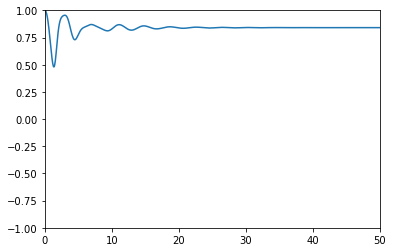

With noise:


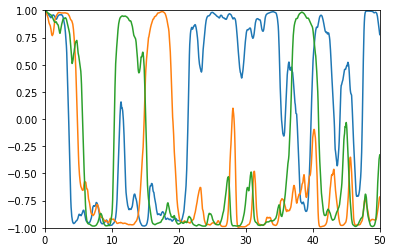

In [6]:
N_steps = 1000
N_trunc = 8

print("Without noise:")
hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False)
psis = hops.compute_realizations(1)
sigma_zs = compute_exp_val(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

print("With noise:")
hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False)
for i in range(3):
    psis = hops.compute_realizations(1)
    sigma_zs = compute_exp_val(psis, sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

# Varying the Step Count

In [8]:
N_steps_list = [500, 1000, 2000]
N_trunc = 8
N_samples = 1

psi_list_step_count_no_noise = []

for N_steps in N_steps_list:
    print("N_steps =", N_steps)
    hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False)
    psis = hops.compute_realizations(N_samples, progressBar=tqdm)
    psi_list_step_count_no_noise.append(psis)

N_steps = 500


  0%|          | 0/1 [00:00<?, ?it/s]

N_steps = 1000


  0%|          | 0/1 [00:00<?, ?it/s]

N_steps = 2000


  0%|          | 0/1 [00:00<?, ?it/s]

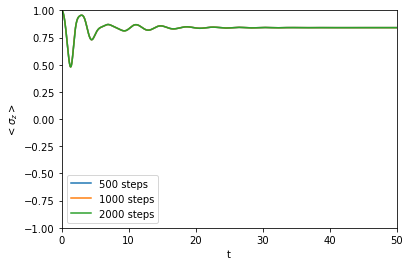

In [9]:
N_steps_list = [500, 1000, 2000]
for i, N_steps in enumerate(N_steps_list):
    sigma_zs = compute_exp_val(psi_list_step_count_no_noise[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label=str(N_steps)+" steps")
plt.legend()
plt.xlabel("t")
plt.ylabel("$<\sigma_z>$")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

In [ ]:
N_steps_list = [500, 1000, 2000]
N_trunc = 8
N_samples = 1000

psi_list_step_count = []

for N_steps in N_steps_list:
    print("N_steps =", N_steps)
    hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False)
    psis = hops.compute_realizations(N_samples, progressBar=tqdm)
    psi_list_step_count.append(psis)

N_steps = 500


  0%|          | 0/1000 [00:00<?, ?it/s]

N_steps = 1000


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
N_steps_list = [500, 1000, 2000]
for i, N_steps in enumerate(N_steps_list):
    sigma_zs = compute_exp_val(psi_list_step_count[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label=str(N_steps)+" steps")
plt.legend()
plt.xlabel("t")
plt.ylabel("$<\sigma_z>$")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

# Varying the truncation order

In [ ]:
N_steps = 1000
N_trunc_list = [1, 2, 4, 8, 16]
N_samples = 1

psis_lis_truncation_order_without_noise = []

for N_trunc in N_trunc_list:
    print("N_trunc =", N_trunc)
    hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False)
    psis = hops.compute_realizations(N_samples)
    psis_lis_truncation_order_without_noise.append(psis)

In [ ]:
N_steps = 1000
N_trunc_list = [1, 2, 4, 8, 16]
for i, N_trunc in enumerate(N_trunc_list):
    sigma_zs = compute_exp_val(psis_lis_truncation_order_without_noise[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="$N_{trunc} = "+str(N_trunc)+"$")
plt.legend()
plt.xlabel("t")
plt.ylabel("$<\sigma_z>$")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

In [ ]:
N_steps = 1000
N_trunc_list = [1, 2, 4, 8, 16]
N_samples = 1000

psis_lis_truncation_order_with_noise = []

for N_trunc in N_trunc_list:
    print("N_trunc =", N_trunc)
    hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False)
    psis = hops.compute_realizations(N_samples, progressBar=tqdm)
    psis_lis_truncation_order_with_noise.append(psis)

In [ ]:
N_trunc_list = [1, 2, 4, 8, 16]
for i, N_trunc in enumerate(N_trunc_list):
    sigma_zs = compute_exp_val(psis_lis_truncation_order_with_noise[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="$N_{trunc} = "+str(N_trunc)+"$")
plt.legend(loc="right")
plt.xlabel("t")
plt.ylabel("$<\sigma_z>$")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

# Varying the number of samples

In [ ]:
N_steps = 1000
N_trunc = 16

In [ ]:
hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False)

In [ ]:
psis_100 = hops.compute_realizations(N_samples=100, progressBar=tqdm)

In [ ]:
psis_1000 = hops.compute_realizations(N_samples=1000, progressBar=tqdm)

In [ ]:
psis_10000 = hops.compute_realizations(N_samples=10000, progressBar=tqdm)

In [ ]:
sigma_zs_100 = compute_exp_val(psis_100, sigma_z)
sigma_zs_1000 = compute_exp_val(psis_1000, sigma_z)
sigma_zs_10000 = compute_exp_val(psis_10000, sigma_z)

In [ ]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
#plt.plot(np.linspace(0, duration, N_steps), sigma_zs_10000, label="10000 samples")
plt.legend()
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.xlabel("t")
plt.ylabel("$<\sigma_z>$")
plt.show()

# Varying the number of samples (with additional norm correction term)

In [ ]:
N_steps = 1000
N_trunc = 16

In [ ]:
hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_norm_term=True)

In [ ]:
psis_100_norm_correction = hops.compute_realizations(N_samples=100, progressBar=tqdm)

In [ ]:
psis_1000_norm_correction = hops.compute_realizations(N_samples=1000, progressBar=tqdm)

In [ ]:
psis_10000_norm_correction = hops.compute_realizations(N_samples=10000, progressBar=tqdm)

In [ ]:
sigma_zs_100_norm_correction = compute_exp_val(psis_100_norm_correction, sigma_z)
sigma_zs_1000_norm_correction = compute_exp_val(psis_1000_norm_correction, sigma_z)
sigma_zs_10000_norm_correction = compute_exp_val(psis_10000_norm_correction, sigma_z)

In [ ]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100_norm_correction, label="100 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000_norm_correction, label="1000 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_10000_norm_correction, label="10000 samples")
plt.legend()
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

## Comparing samples with and without norm correction

In [ ]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100_norm_correction, label="with norm correction")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="no norm correction")
plt.legend()
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.title("Difference of using norm correction term (100 samples)")
plt.show()

plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000_norm_correction, label="with norm correction")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="no norm correction")
plt.legend()
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.title("Difference of using norm correction term (1000 samples)")
plt.show()

plt.plot(np.linspace(0, duration, N_steps), sigma_zs_10000_norm_correction, label="with norm correction")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_10000, label="no norm correction")
plt.legend()
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.title("Difference of using norm correction term (10000 samples)")
plt.show()

# Test if the memory terms are updated correctly

In [3]:
N_steps = 1000
N_trunc = 16

In [9]:
hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False)

In [15]:
psis, memory = hops.compute_memory_realization()

In [23]:
# compute memory by approximating the integrals with sums
def compute_memory(psis, t_index, expLs):
    result = np.array([0], dtype=complex)
    for s_index in range(t_index):
        result += np.conj(bath_correlation_function.alpha(hops.ts[t_index*2] - hops.ts[s_index*2], g, w)) * expLs[s_index]
    return (result * hops.dt).item()

In [24]:
memory_compare = []
expLs = []
for t_index in tqdm(range(N_steps)):
    expLs.append(np.real_if_close((np.conj(psis[t_index, :]).T@sigma_z@psis[t_index, :])/(np.conj(psis[t_index, :]).T@psis[t_index, :]))) 
for t_index in tqdm(range(N_steps)):
    memory_compare.append(compute_memory(psis, t_index, expLs))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

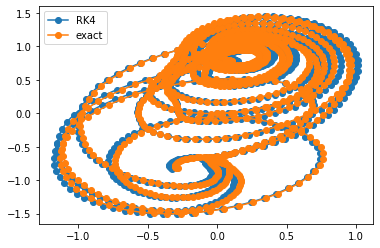

In [27]:
plt.plot(np.real(memory), np.imag(memory), "o-", label="RK4")
plt.plot(np.real(memory_compare), np.imag(memory_compare), "o-", label="exact")
plt.legend()
plt.show()

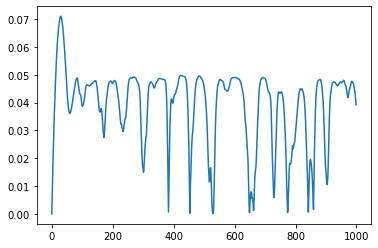

In [30]:
plt.plot(np.abs(memory - np.array(memory_compare)))
plt.show()